# Person Counting using YOLO11

This notebook demonstrates person counting using Ultralytics YOLO11.

**Objectives:**
- Aggregate detection results to provide accurate headcount
- Implement zone-based counting with ROI regions
- Generate counting statistics for videos
- Create crowd density estimation and heatmaps

**Model:** YOLO11s (small variant - optimized for CPU)

## 1. Setup & Installation

In [ ]:
# Install required packages (run once)
# !pip install ultralytics opencv-python matplotlib pandas tqdm

In [1]:
# Import libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict
import json

from ultralytics import YOLO

# Set up paths
PROJECT_ROOT = Path("../")
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "counting"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load YOLO11s model
model = YOLO("yolo11s.pt")

print(f"Model: {model.model_name}")
print(f"Task: {model.task}")
print(f"Person class ID: 0")

Model: yolo11s.pt
Task: detect
Person class ID: 0


## 2. Download Sample Images

In [3]:
# Download sample images for testing
import urllib.request

sample_images = {
    "bus.jpg": "https://ultralytics.com/images/bus.jpg",
    "zidane.jpg": "https://ultralytics.com/images/zidane.jpg"
}

images_dir = DATA_DIR / "images"
images_dir.mkdir(parents=True, exist_ok=True)

for filename, url in sample_images.items():
    filepath = images_dir / filename
    if not filepath.exists():
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filepath)
    else:
        print(f"{filename} already exists")

print("\nSample images ready!")

bus.jpg already exists
zidane.jpg already exists

Sample images ready!


## 3. Simple Frame Counting

In [4]:
def count_persons(image_source, model, conf_threshold=0.25):
    """
    Count persons in an image.
    
    Args:
        image_source: Path to image or image array
        model: YOLO model instance
        conf_threshold: Confidence threshold
    
    Returns:
        count: Number of persons detected
        results: Detection results
        details: List of detection details
    """
    results = model.predict(
        source=image_source,
        classes=[0],  # Person class only
        conf=conf_threshold,
        verbose=False
    )
    
    count = len(results[0].boxes)
    
    details = []
    for i, box in enumerate(results[0].boxes):
        details.append({
            "id": i,
            "confidence": float(box.conf[0]),
            "bbox": box.xyxy[0].tolist(),
            "center": ((box.xyxy[0][0] + box.xyxy[0][2]) / 2,
                       (box.xyxy[0][1] + box.xyxy[0][3]) / 2)
        })
    
    return count, results, details

In [5]:
# Count persons in sample image
image_path = DATA_DIR / "images" / "bus.jpg"
count, results, details = count_persons(image_path, model)

print(f"Image: {image_path.name}")
print(f"Persons detected: {count}")
print("\nDetection details:")
for det in details:
    print(f"  Person {det['id']}: confidence={det['confidence']:.2f}, center=({det['center'][0]:.0f}, {det['center'][1]:.0f})")

Image: bus.jpg
Persons detected: 4

Detection details:
  Person 0: confidence=0.90, center=(740, 634)
  Person 1: confidence=0.88, center=(150, 652)
  Person 2: confidence=0.87, center=(284, 633)
  Person 3: confidence=0.66, center=(40, 715)


In [6]:
def draw_count_overlay(image, count, position="top-left", font_scale=1.5):
    """
    Draw person count overlay on image.
    
    Args:
        image: Image array (BGR)
        count: Person count
        position: Position of overlay ("top-left", "top-right", "bottom-left", "bottom-right")
        font_scale: Font size scale
    
    Returns:
        image: Image with overlay
    """
    img = image.copy()
    h, w = img.shape[:2]
    
    text = f"Count: {count}"
    font = cv2.FONT_HERSHEY_SIMPLEX
    thickness = 3
    
    # Get text size
    (text_w, text_h), baseline = cv2.getTextSize(text, font, font_scale, thickness)
    
    # Calculate position
    padding = 15
    if position == "top-left":
        x, y = padding, text_h + padding
    elif position == "top-right":
        x, y = w - text_w - padding, text_h + padding
    elif position == "bottom-left":
        x, y = padding, h - padding
    else:  # bottom-right
        x, y = w - text_w - padding, h - padding
    
    # Draw background rectangle
    cv2.rectangle(img, (x - 10, y - text_h - 10), (x + text_w + 10, y + 10), (0, 0, 0), -1)
    cv2.rectangle(img, (x - 10, y - text_h - 10), (x + text_w + 10, y + 10), (0, 255, 0), 2)
    
    # Draw text
    cv2.putText(img, text, (x, y), font, font_scale, (0, 255, 0), thickness)
    
    return img

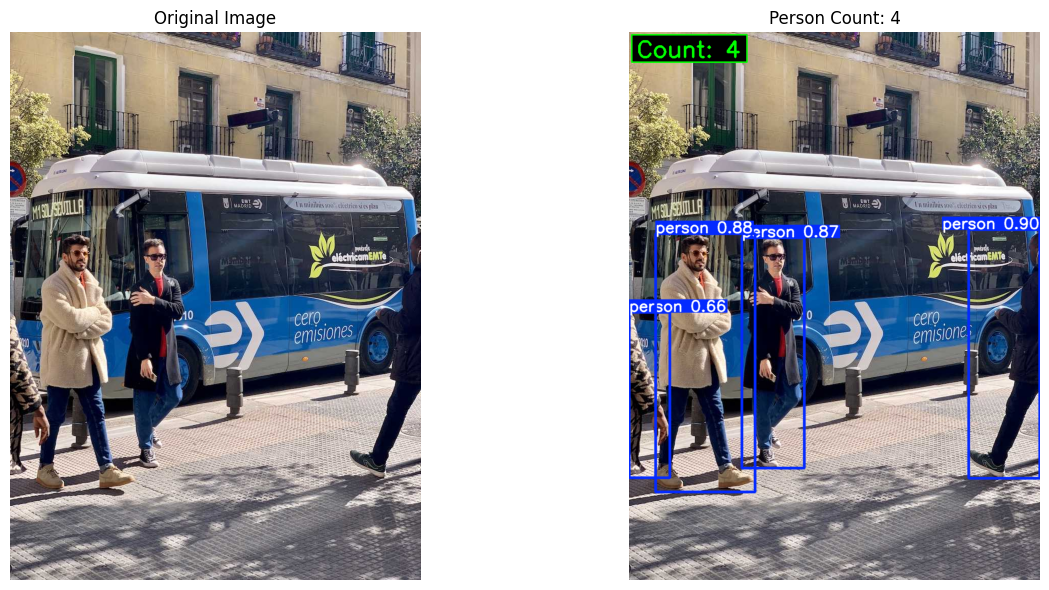

In [7]:
# Display image with count overlay
original = cv2.imread(str(image_path))
annotated = results[0].plot()
with_count = draw_count_overlay(annotated, count)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(with_count, cv2.COLOR_BGR2RGB))
axes[1].set_title(f"Person Count: {count}")
axes[1].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "simple_count.png", dpi=150, bbox_inches='tight')
plt.show()

## 4. Zone-Based Counting

In [8]:
def point_in_polygon(point, polygon):
    """
    Check if a point is inside a polygon using ray casting.
    
    Args:
        point: (x, y) tuple
        polygon: List of (x, y) tuples defining the polygon
    
    Returns:
        bool: True if point is inside polygon
    """
    x, y = point
    n = len(polygon)
    inside = False
    
    p1x, p1y = polygon[0]
    for i in range(1, n + 1):
        p2x, p2y = polygon[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    
    return inside


def count_in_zones(image_source, model, zones, conf_threshold=0.25):
    """
    Count persons in defined zones.
    
    Args:
        image_source: Path to image or image array
        model: YOLO model instance
        zones: Dictionary of zone_name: polygon_points
        conf_threshold: Confidence threshold
    
    Returns:
        zone_counts: Dictionary of zone_name: count
        results: Detection results
        person_zones: List of (person_id, zone_name or None)
    """
    # Run detection
    results = model.predict(
        source=image_source,
        classes=[0],
        conf=conf_threshold,
        verbose=False
    )
    
    zone_counts = {name: 0 for name in zones.keys()}
    zone_counts['outside'] = 0
    person_zones = []
    
    for i, box in enumerate(results[0].boxes):
        # Get center point of bounding box
        bbox = box.xyxy[0]
        center_x = (bbox[0] + bbox[2]) / 2
        center_y = (bbox[1] + bbox[3]) / 2
        center = (float(center_x), float(center_y))
        
        # Check which zone the person is in
        person_zone = None
        for zone_name, polygon in zones.items():
            if point_in_polygon(center, polygon):
                zone_counts[zone_name] += 1
                person_zone = zone_name
                break
        
        if person_zone is None:
            zone_counts['outside'] += 1
            person_zone = 'outside'
        
        person_zones.append((i, person_zone))
    
    return zone_counts, results, person_zones

In [9]:
# Define counting zones (as percentages of image dimensions for flexibility)
# Load image to get dimensions
img = cv2.imread(str(image_path))
h, w = img.shape[:2]

# Define zones (coordinates as percentages, will be converted to pixels)
zones_pct = {
    "Zone A (Left)": [(0.0, 0.0), (0.4, 0.0), (0.4, 1.0), (0.0, 1.0)],
    "Zone B (Right)": [(0.4, 0.0), (1.0, 0.0), (1.0, 1.0), (0.4, 1.0)]
}

# Convert to pixel coordinates
zones = {}
for name, pct_points in zones_pct.items():
    zones[name] = [(int(x * w), int(y * h)) for x, y in pct_points]

print("Defined zones:")
for name, points in zones.items():
    print(f"  {name}: {points}")

Defined zones:
  Zone A (Left): [(0, 0), (324, 0), (324, 1080), (0, 1080)]
  Zone B (Right): [(324, 0), (810, 0), (810, 1080), (324, 1080)]


In [10]:
# Count persons in zones
zone_counts, results, person_zones = count_in_zones(image_path, model, zones)

print("\nZone Counts:")
for zone_name, count in zone_counts.items():
    print(f"  {zone_name}: {count} person(s)")

print("\nPerson Assignments:")
for person_id, zone in person_zones:
    print(f"  Person {person_id}: {zone}")


Zone Counts:
  Zone A (Left): 3 person(s)
  Zone B (Right): 1 person(s)
  outside: 0 person(s)

Person Assignments:
  Person 0: Zone B (Right)
  Person 1: Zone A (Left)
  Person 2: Zone A (Left)
  Person 3: Zone A (Left)


In [11]:
def draw_zones_with_counts(image, zones, zone_counts, results, person_zones):
    """
    Draw zones and counts on image.
    
    Args:
        image: Image array (BGR)
        zones: Dictionary of zone_name: polygon_points
        zone_counts: Dictionary of zone_name: count
        results: Detection results
        person_zones: List of (person_id, zone_name)
    
    Returns:
        image: Annotated image
    """
    img = image.copy()
    
    # Colors for different zones
    colors = {
        "Zone A (Left)": (255, 0, 0),    # Blue
        "Zone B (Right)": (0, 255, 0),   # Green
        "outside": (128, 128, 128)       # Gray
    }
    
    # Draw zone polygons
    overlay = img.copy()
    for zone_name, polygon in zones.items():
        color = colors.get(zone_name, (0, 255, 255))
        pts = np.array(polygon, dtype=np.int32)
        cv2.fillPoly(overlay, [pts], color)
    
    # Blend overlay
    img = cv2.addWeighted(overlay, 0.2, img, 0.8, 0)
    
    # Draw zone boundaries
    for zone_name, polygon in zones.items():
        color = colors.get(zone_name, (0, 255, 255))
        pts = np.array(polygon, dtype=np.int32)
        cv2.polylines(img, [pts], True, color, 2)
    
    # Draw detections with zone colors
    for i, box in enumerate(results[0].boxes):
        # Find zone for this person
        zone = next((z for pid, z in person_zones if pid == i), 'outside')
        color = colors.get(zone, (128, 128, 128))
        
        bbox = box.xyxy[0].cpu().numpy().astype(int)
        cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)
        
        # Draw person label
        label = f"P{i}"
        cv2.putText(img, label, (bbox[0], bbox[1] - 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    # Draw zone count labels
    for zone_name, polygon in zones.items():
        color = colors.get(zone_name, (0, 255, 255))
        # Get center of zone
        center_x = int(np.mean([p[0] for p in polygon]))
        center_y = int(np.mean([p[1] for p in polygon]))
        
        count = zone_counts.get(zone_name, 0)
        text = f"{zone_name}: {count}"
        
        # Draw background
        (text_w, text_h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
        cv2.rectangle(img, (center_x - text_w//2 - 5, center_y - text_h - 5),
                      (center_x + text_w//2 + 5, center_y + 5), (0, 0, 0), -1)
        cv2.putText(img, text, (center_x - text_w//2, center_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    
    return img

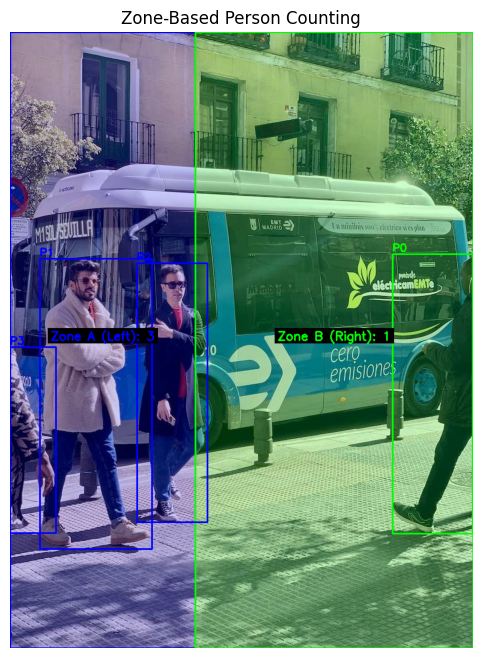

In [12]:
# Visualize zone-based counting
zone_image = draw_zones_with_counts(img, zones, zone_counts, results, person_zones)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(zone_image, cv2.COLOR_BGR2RGB))
plt.title("Zone-Based Person Counting")
plt.axis('off')
plt.savefig(OUTPUT_DIR / "zone_counting.png", dpi=150, bbox_inches='tight')
plt.show()

## 5. Video Counting with Statistics

In [13]:
def process_video_counting(video_path, model, output_path, zones=None, conf_threshold=0.25):
    """
    Process video with person counting.
    
    Args:
        video_path: Path to input video
        model: YOLO model instance
        output_path: Path to save output video
        zones: Optional dictionary of zones for zone-based counting
        conf_threshold: Confidence threshold
    
    Returns:
        frame_stats: List of per-frame statistics
    """
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Processing: {video_path}")
    print(f"  Resolution: {width}x{height}")
    print(f"  FPS: {fps}, Frames: {total_frames}")
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))
    
    # Convert zone percentages to pixels if provided
    pixel_zones = None
    if zones:
        pixel_zones = {}
        for name, pct_points in zones.items():
            pixel_zones[name] = [(int(x * width), int(y * height)) for x, y in pct_points]
    
    frame_stats = []
    
    for frame_idx in tqdm(range(total_frames), desc="Processing frames"):
        ret, frame = cap.read()
        if not ret:
            break
        
        if pixel_zones:
            zone_counts, results, person_zones = count_in_zones(frame, model, pixel_zones, conf_threshold)
            annotated = draw_zones_with_counts(frame, pixel_zones, zone_counts, results, person_zones)
            total_count = sum(zone_counts.values())
            
            stats = {
                "frame": frame_idx,
                "total_count": total_count,
                "zone_counts": zone_counts.copy()
            }
        else:
            count, results, _ = count_persons(frame, model, conf_threshold)
            annotated = results[0].plot()
            annotated = draw_count_overlay(annotated, count)
            
            stats = {
                "frame": frame_idx,
                "total_count": count
            }
        
        frame_stats.append(stats)
        out.write(annotated)
    
    cap.release()
    out.release()
    
    print(f"Output saved to: {output_path}")
    return frame_stats

In [14]:
# Check for available videos
video_dir = DATA_DIR / "videos"
video_extensions = [".mp4", ".avi", ".mov", ".mkv"]
videos = [f for f in video_dir.iterdir() if f.suffix.lower() in video_extensions] if video_dir.exists() else []

if videos:
    print(f"Found {len(videos)} video(s)")
    video_path = videos[0]
    output_path = OUTPUT_DIR / f"{video_path.stem}_counted.mp4"
    
    # Define zones for video (using percentages)
    video_zones = {
        "Zone A": [(0.0, 0.0), (0.5, 0.0), (0.5, 1.0), (0.0, 1.0)],
        "Zone B": [(0.5, 0.0), (1.0, 0.0), (1.0, 1.0), (0.5, 1.0)]
    }
    
    frame_stats = process_video_counting(
        video_path=video_path,
        model=model,
        output_path=output_path,
        zones=video_zones,
        conf_threshold=0.25
    )
else:
    print("No videos found in data/videos/")
    print("Creating simulated frame stats for demonstration...")
    
    # Simulate frame stats for demonstration
    np.random.seed(42)
    frame_stats = []
    for i in range(100):
        base_count = 5 + np.sin(i / 10) * 3
        noise = np.random.normal(0, 1)
        total = max(0, int(base_count + noise))
        frame_stats.append({
            "frame": i,
            "total_count": total,
            "zone_counts": {
                "Zone A": max(0, int(total * 0.4 + np.random.normal(0, 0.5))),
                "Zone B": max(0, int(total * 0.6 + np.random.normal(0, 0.5)))
            }
        })

Found 1 video(s)
Processing: ../data/videos/Bangkok.mp4
  Resolution: 1280x720
  FPS: 25, Frames: 650


Processing frames: 100%|██████████| 650/650 [00:36<00:00, 17.77it/s]

Output saved to: ../outputs/counting/Bangkok_counted.mp4


In [15]:
# Analyze and visualize counting statistics
frames = [s['frame'] for s in frame_stats]
counts = [s['total_count'] for s in frame_stats]

# Calculate statistics
min_count = min(counts)
max_count = max(counts)
avg_count = np.mean(counts)
std_count = np.std(counts)

print("Counting Statistics:")
print(f"  Min: {min_count}")
print(f"  Max: {max_count}")
print(f"  Average: {avg_count:.2f}")
print(f"  Std Dev: {std_count:.2f}")
print(f"  Total frames: {len(frames)}")

Counting Statistics:
  Min: 11
  Max: 20
  Average: 15.24
  Std Dev: 1.61
  Total frames: 650


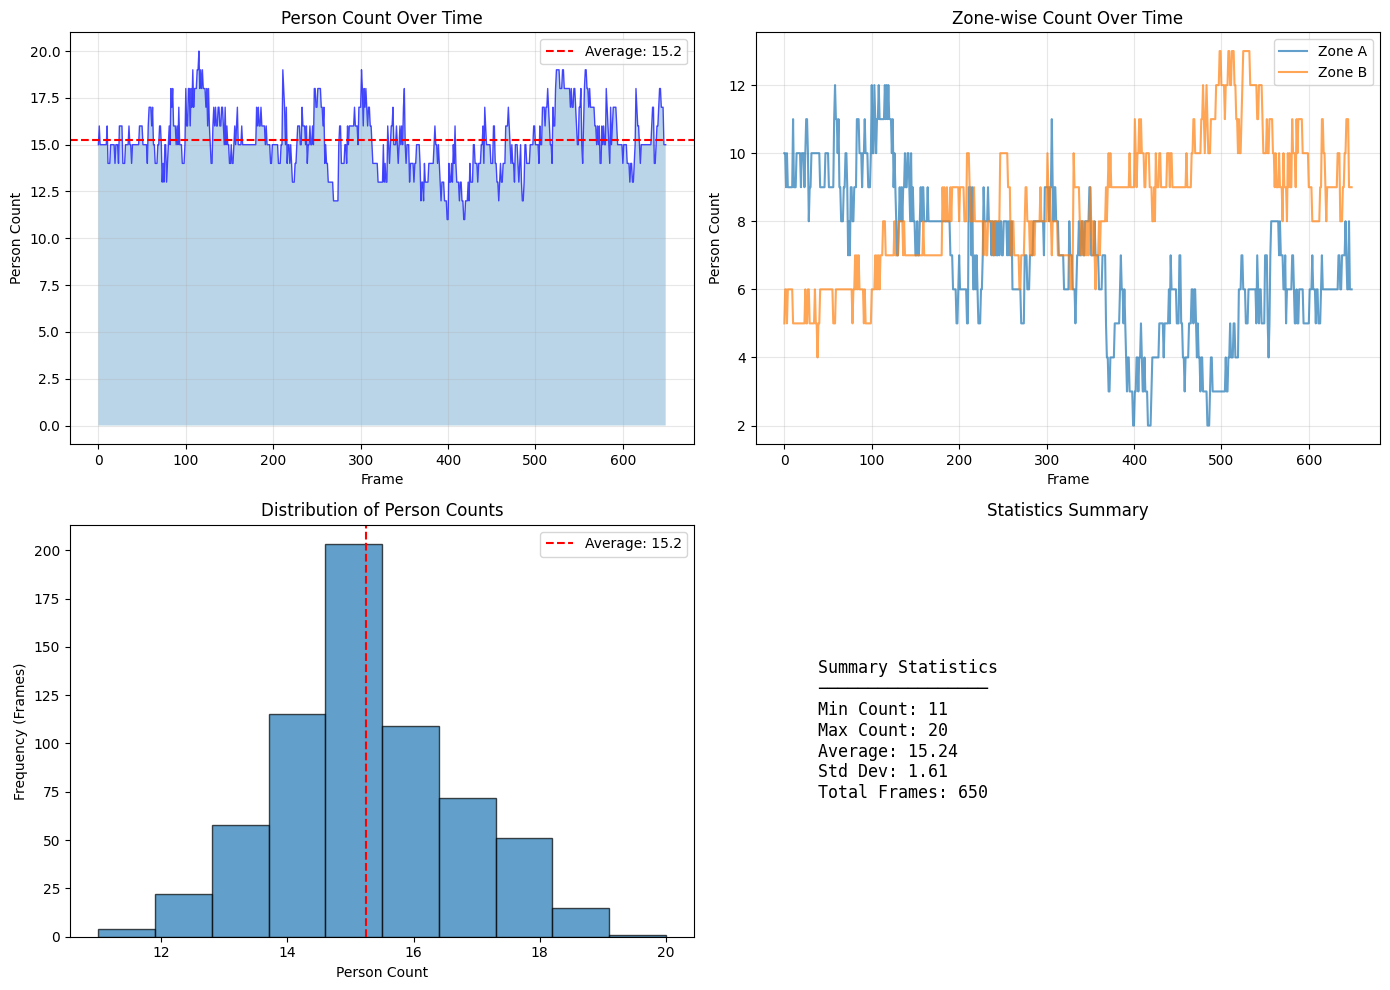

In [16]:
# Plot count over time
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total count over time
axes[0, 0].plot(frames, counts, 'b-', linewidth=1, alpha=0.7)
axes[0, 0].fill_between(frames, counts, alpha=0.3)
axes[0, 0].axhline(avg_count, color='r', linestyle='--', label=f'Average: {avg_count:.1f}')
axes[0, 0].set_xlabel('Frame')
axes[0, 0].set_ylabel('Person Count')
axes[0, 0].set_title('Person Count Over Time')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Zone comparison (if zones were used)
if 'zone_counts' in frame_stats[0]:
    zone_names = list(frame_stats[0]['zone_counts'].keys())
    for zone_name in zone_names:
        if zone_name != 'outside':
            zone_counts_list = [s['zone_counts'].get(zone_name, 0) for s in frame_stats]
            axes[0, 1].plot(frames, zone_counts_list, label=zone_name, alpha=0.7)
    axes[0, 1].set_xlabel('Frame')
    axes[0, 1].set_ylabel('Person Count')
    axes[0, 1].set_title('Zone-wise Count Over Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'No zone data', ha='center', va='center')

# Histogram of counts
axes[1, 0].hist(counts, bins=max(10, max_count - min_count + 1), edgecolor='black', alpha=0.7)
axes[1, 0].axvline(avg_count, color='r', linestyle='--', label=f'Average: {avg_count:.1f}')
axes[1, 0].set_xlabel('Person Count')
axes[1, 0].set_ylabel('Frequency (Frames)')
axes[1, 0].set_title('Distribution of Person Counts')
axes[1, 0].legend()

# Summary statistics box
stats_text = f"""Summary Statistics
─────────────────
Min Count: {min_count}
Max Count: {max_count}
Average: {avg_count:.2f}
Std Dev: {std_count:.2f}
Total Frames: {len(frames)}"""

axes[1, 1].text(0.1, 0.5, stats_text, fontfamily='monospace', fontsize=12,
                verticalalignment='center', transform=axes[1, 1].transAxes)
axes[1, 1].axis('off')
axes[1, 1].set_title('Statistics Summary')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "counting_statistics.png", dpi=150, bbox_inches='tight')
plt.show()

## 6. Crowd Density Estimation

In [17]:
def calculate_density_map(image_shape, detections, kernel_size=50):
    """
    Create a density heatmap from person detections.
    
    Args:
        image_shape: (H, W) tuple of image dimensions
        detections: List of detection dictionaries with 'center' key
        kernel_size: Size of Gaussian kernel for smoothing
    
    Returns:
        density_map: 2D density array
    """
    h, w = image_shape[:2]
    density_map = np.zeros((h, w), dtype=np.float32)
    
    for det in detections:
        cx, cy = int(det['center'][0]), int(det['center'][1])
        if 0 <= cx < w and 0 <= cy < h:
            density_map[cy, cx] = 1.0
    
    # Apply Gaussian blur for smooth density
    if kernel_size > 0:
        density_map = cv2.GaussianBlur(density_map, (kernel_size * 2 + 1, kernel_size * 2 + 1), kernel_size)
    
    # Normalize
    if density_map.max() > 0:
        density_map = density_map / density_map.max()
    
    return density_map

In [18]:
def create_density_heatmap_overlay(image, density_map, alpha=0.5):
    """
    Overlay density heatmap on image.
    
    Args:
        image: Original image (BGR)
        density_map: 2D density array
        alpha: Transparency of overlay
    
    Returns:
        overlay: Image with heatmap overlay
    """
    # Convert density to colormap
    density_uint8 = (density_map * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(density_uint8, cv2.COLORMAP_JET)
    
    # Blend with original image
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    
    return overlay

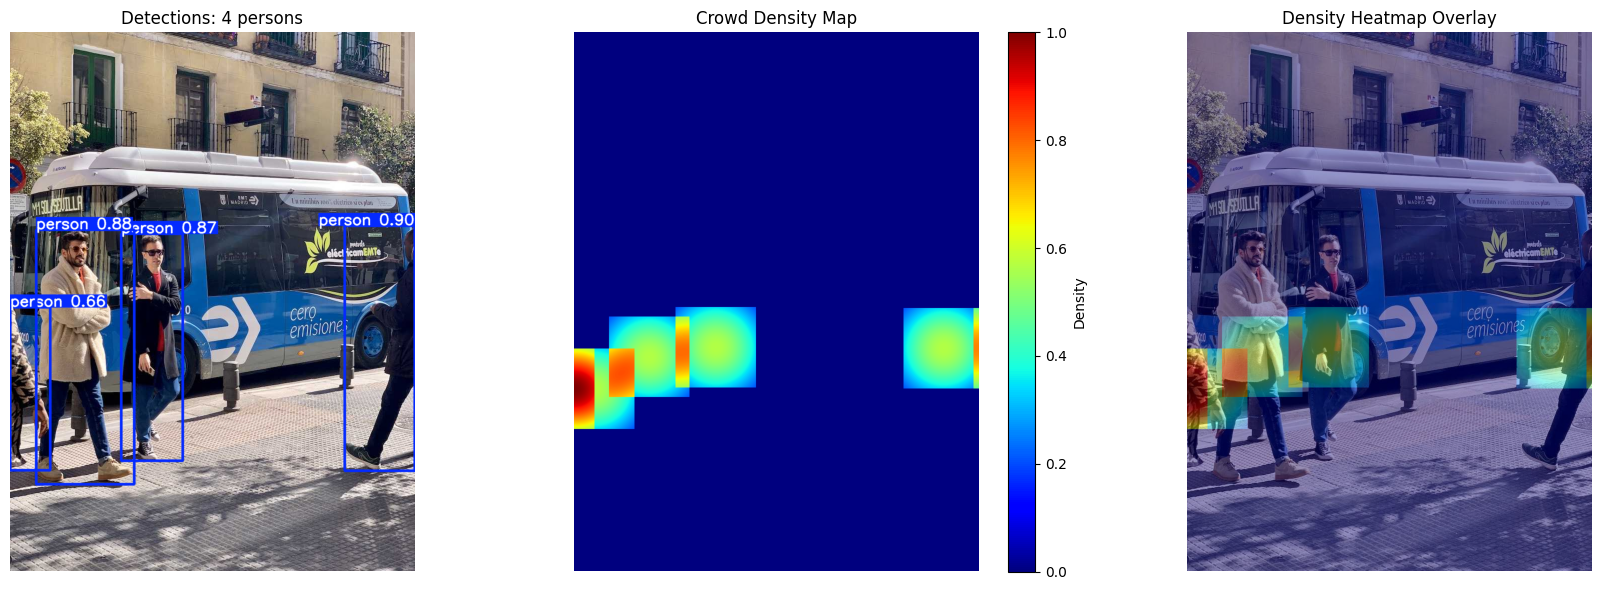

In [19]:
# Create density heatmap for sample image
image = cv2.imread(str(image_path))
count, results, details = count_persons(image_path, model)

# Calculate density map
density_map = calculate_density_map(image.shape, details, kernel_size=80)

# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original with detections
annotated = results[0].plot()
axes[0].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
axes[0].set_title(f"Detections: {count} persons")
axes[0].axis('off')

# Density map
im = axes[1].imshow(density_map, cmap='jet', vmin=0, vmax=1)
axes[1].set_title("Crowd Density Map")
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], label='Density')

# Overlay
overlay = create_density_heatmap_overlay(image, density_map, alpha=0.4)
axes[2].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
axes[2].set_title("Density Heatmap Overlay")
axes[2].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "density_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()

## 7. Export Counting Results

In [20]:
# Export frame statistics to CSV
if frame_stats:
    # Create DataFrame
    df_data = []
    for stat in frame_stats:
        row = {
            'frame': stat['frame'],
            'total_count': stat['total_count']
        }
        if 'zone_counts' in stat:
            for zone_name, count in stat['zone_counts'].items():
                row[f'count_{zone_name}'] = count
        df_data.append(row)
    
    df = pd.DataFrame(df_data)
    csv_path = OUTPUT_DIR / "counting_results.csv"
    df.to_csv(csv_path, index=False)
    print(f"Results saved to: {csv_path}")
    print(f"\nDataFrame preview:")
    display(df.head(10))
    
    # Export summary statistics
    summary = {
        "total_frames": len(frame_stats),
        "min_count": min_count,
        "max_count": max_count,
        "average_count": float(avg_count),
        "std_dev": float(std_count)
    }
    
    json_path = OUTPUT_DIR / "counting_summary.json"
    with open(json_path, 'w') as f:
        json.dump(summary, f, indent=2)
    print(f"\nSummary saved to: {json_path}")

Results saved to: ../outputs/counting/counting_results.csv

DataFrame preview:


,frame,total_count,count_Zone A,count_Zone B,count_outside
0,0,15,10,5,0
1,1,16,10,6,0
2,2,15,9,6,0
3,3,15,10,5,0
4,4,15,9,6,0
5,5,15,9,6,0
6,6,15,9,6,0
7,7,15,9,6,0
8,8,15,9,6,0
9,9,15,9,6,0



Summary saved to: ../outputs/counting/counting_summary.json


## 8. Interactive Counting (Custom Images)

In [21]:
# Example: Count persons in a custom image
# Uncomment and modify the path below:

# custom_image = "/path/to/your/image.jpg"
# count, results, details = count_persons(custom_image, model)
# 
# print(f"Persons detected: {count}")
# 
# # Show with count overlay
# img = cv2.imread(custom_image)
# annotated = results[0].plot()
# with_overlay = draw_count_overlay(annotated, count)
# 
# plt.figure(figsize=(12, 8))
# plt.imshow(cv2.cvtColor(with_overlay, cv2.COLOR_BGR2RGB))
# plt.title(f"Person Count: {count}")
# plt.axis('off')
# plt.show()

## Summary

This notebook demonstrated:
1. **Simple Counting**: Basic person count per image/frame
2. **Zone-Based Counting**: Counting within defined ROI regions
3. **Video Counting**: Frame-by-frame counting with statistics
4. **Crowd Density**: Heatmap visualization of crowd distribution
5. **Statistics Export**: CSV and JSON export of counting results

**Key Features:**
- Zone polygon support for area-specific counting
- Statistical analysis (min, max, average, std dev)
- Density heatmap generation
- Multiple output formats (video, CSV, JSON, images)

**Next Steps:**
- Integrate with multi-object tracking for counting unique individuals
- Add line-crossing counting for entrance/exit monitoring
- Implement real-time counting from webcam stream